In [1]:
import torch, torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist = torchvision.datasets.MNIST('./', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./', train=False, download=True, transform=torchvision.transforms.ToTensor())



In [3]:
from torch.utils.data import DataLoader

def train(model, dl, optimizer):
    model.train()
    model.cuda()
    loss_fn = torch.nn.CrossEntropyLoss()

    loss_list = [] #To plot loss graph later
    for train_images, train_labels in dl:
        ## Move data to GPU
        train_images, train_labels = train_images.cuda(), train_labels.cuda()
        ## Flatten the images 
        flat_images = train_images.reshape(-1, 784)
        ## Run the network with flattened images 
        class_scores = model(flat_images)
        ## Calculate loss loss_fn defined with network output and labels from dataset
        loss = loss_fn(class_scores, train_labels)
        ## optimize 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ## record loss
        loss_list.append(loss.item())

    return model, loss_list

    
def evaluate(model, dl):
    model.eval()
    model.cuda()
    true_predictions = 0
    false_predictions = 0
    for test_images, test_labels in dl:
        ## Move batch to GPU
        test_images, test_labels = test_images.cuda(), test_labels.cuda()
        ## Flatten the images from [BATCH, 1, 28, 28] to [BATCH, 784]
        flat_images = test_images.reshape(-1, 784)
        ## Run the network with flattened images 
        with torch.no_grad():
            class_scores = model(flat_images)
        ## Extract predictions from class_scores using torch.argmax() method
        class_predictions = torch.argmax(class_scores, axis=-1)
        ## Find the number of true predictions in the batch using test_labels and class_predictions
        true_predictions_batch  = torch.sum(class_predictions == test_labels)
        false_predictions_batch = torch.sum(class_predictions != test_labels)
        true_predictions  += true_predictions_batch.item()
        false_predictions += false_predictions_batch.item()
    
    accuracy = true_predictions / (true_predictions + false_predictions)
    return accuracy


def run_experiment(model, lr, bs, optim_cls):
    optimizer = optim_cls(model.parameters(), lr=lr)

    train_dataloader = DataLoader(mnist, batch_size=bs, shuffle=True)
    model, losses = train(model, train_dataloader, optimizer)

    test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=False)
    accuracy = evaluate(model, test_dataloader)
    return model, losses, accuracy

In [4]:
class OneLayerNetwork(torch.nn.Module):
    def __init__(self):
      super().__init__()
      self.linear = torch.nn.Linear(28*28, 10)
     
    def forward(self, x):
        return self.linear(x)


In [5]:
# Helper for plotting the loss graph smoothly. 
def smoothen_losses(loss_list):
    filter_size = 10
    moving_average_filter = [1/filter_size] * filter_size
    return np.convolve(loss_list, moving_average_filter, 'valid') 

def plot_loss_graph(*results):
    fig = plt.figure(figsize=(12, 8))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    for losses, label in results:
        plt.plot(smoothen_losses(losses), label=label)
    plt.legend()
    return fig    


### Learning rate

In [6]:
import itertools

def run_all_experiments(model_fn, lr_space, bs_space, optimizer_space):
    experiment_results = []
    for i, (lr, bs, optim_cls) in enumerate(itertools.product(lr_space, bs_space, optimizer_space)):
        print("==========================================")
        print(f"Experiment {i+1}")
        print("==========================================")
        print(f"Learning rate = {lr}")
        print(f"Batch size = {bs}")
        print(f"Optimizer = {optim_cls.__name__}")
        model, loss_list, accuracy = run_experiment(model_fn(), lr, bs, optim_cls)
        experiment_results.append(
            (dict(lr=lr,bs=bs,optim_cls=optim_cls), dict(model=model, loss_list=loss_list, accuracy=accuracy))
        )
        print(f'Accuracy = {accuracy*100:.1f}%')
        print("==========================================")
    
    return experiment_results

Experiment 1
Learning rate = 0.1
Batch size = 32
Optimizer = SGD
Accuracy = 91.4%
Experiment 2
Learning rate = 0.01
Batch size = 32
Optimizer = SGD
Accuracy = 88.3%
Experiment 3
Learning rate = 0.001
Batch size = 32
Optimizer = SGD
Accuracy = 80.8%
Experiment 4
Learning rate = 0.0001
Batch size = 32
Optimizer = SGD
Accuracy = 40.5%


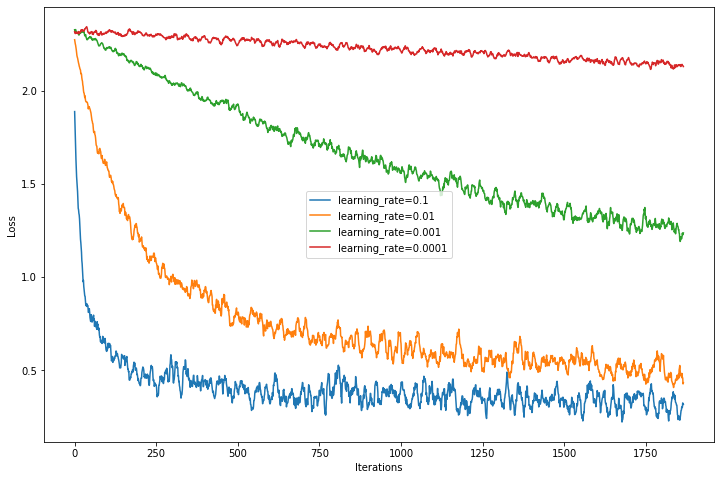

In [7]:
experiment_results = run_all_experiments(
    OneLayerNetwork,
    lr_space = [1e-1, 1e-2, 1e-3, 1e-4],
    bs_space=[32], 
    optimizer_space = [torch.optim.SGD]
)
fig = plot_loss_graph(*[(output['loss_list'], f"learning_rate={inp['lr']}") for inp, output in experiment_results])

With batch size of 16 and SGD optimizer, it can be seen from above that when learning rate is too small such as 1e-4, it takes much longer to minimize loss. 

### Batch size

Experiment 1
Learning rate = 0.01
Batch size = 8
Optimizer = SGD
Accuracy = 90.5%
Experiment 2
Learning rate = 0.01
Batch size = 16
Optimizer = SGD
Accuracy = 89.5%
Experiment 3
Learning rate = 0.01
Batch size = 32
Optimizer = SGD
Accuracy = 88.5%
Experiment 4
Learning rate = 0.01
Batch size = 64
Optimizer = SGD
Accuracy = 86.6%
Experiment 5
Learning rate = 0.01
Batch size = 128
Optimizer = SGD
Accuracy = 84.5%


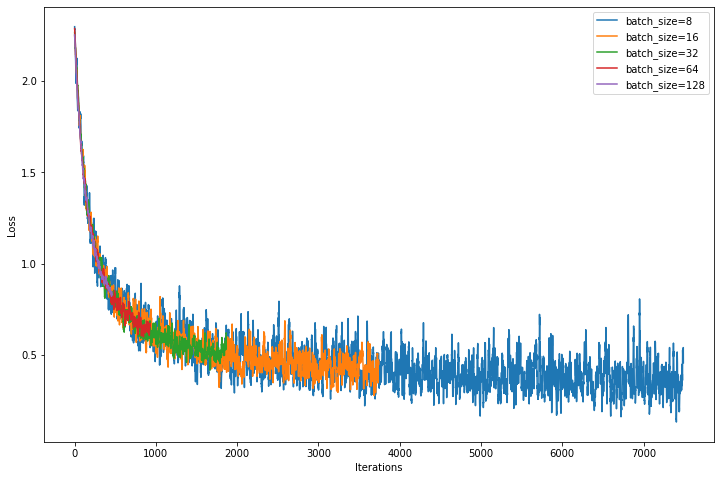

In [8]:
experiment_results = run_all_experiments(
    OneLayerNetwork,
    lr_space = [1e-2],
    bs_space = [8, 16, 32, 64, 128],
    optimizer_space = [torch.optim.SGD]
)
fig = plot_loss_graph(*[(output['loss_list'], f"batch_size={inp['bs']}") for inp, output in experiment_results])

With learning rate of 1e-2 and SGD optimizer, as it can be seen above, loss shows more variance with smaller batch sizes; while test accuracy increases. This might be because small batch size may act as a regularizer and prevent the model to overfit, hence, to perform better on test set. 

### Optimizer

Experiment 1
Learning rate = 0.01
Batch size = 32
Optimizer = SGD
Accuracy = 88.3%
Experiment 2
Learning rate = 0.01
Batch size = 32
Optimizer = Adam
Accuracy = 90.6%


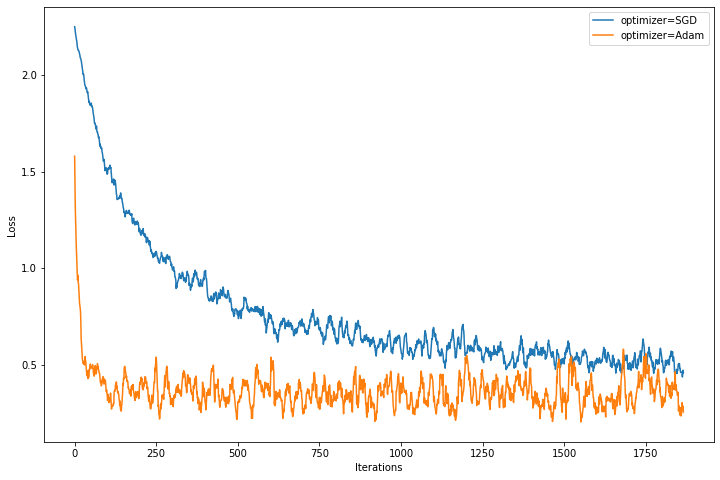

In [9]:
experiment_results = run_all_experiments(
    OneLayerNetwork,
    lr_space=[1e-2], 
    bs_space=[32], 
    optimizer_space=[torch.optim.SGD, torch.optim.Adam]
)
fig = plot_loss_graph(*[(output['loss_list'], f"optimizer={inp['optim_cls'].__name__}") for inp, output in experiment_results])

With learning rate of 1e-2 and batch size of 32, as it can be seen above, Adam optimizer converges much faster and yields smaller loss at the same number of iterations.

Let's train our model with best hyper parameters and visualize weights.

Experiment 1
Learning rate = 0.1
Batch size = 8
Optimizer = SGD
Accuracy = 91.8%
Experiment 2
Learning rate = 0.1
Batch size = 8
Optimizer = Adam
Accuracy = 88.9%
Experiment 3
Learning rate = 0.1
Batch size = 32
Optimizer = SGD
Accuracy = 91.3%
Experiment 4
Learning rate = 0.1
Batch size = 32
Optimizer = Adam
Accuracy = 88.7%
Experiment 5
Learning rate = 0.1
Batch size = 64
Optimizer = SGD
Accuracy = 90.5%
Experiment 6
Learning rate = 0.1
Batch size = 64
Optimizer = Adam
Accuracy = 87.3%
Experiment 7
Learning rate = 0.01
Batch size = 8
Optimizer = SGD
Accuracy = 90.4%
Experiment 8
Learning rate = 0.01
Batch size = 8
Optimizer = Adam
Accuracy = 87.1%
Experiment 9
Learning rate = 0.01
Batch size = 32
Optimizer = SGD
Accuracy = 88.3%
Experiment 10
Learning rate = 0.01
Batch size = 32
Optimizer = Adam
Accuracy = 90.9%
Experiment 11
Learning rate = 0.01
Batch size = 64
Optimizer = SGD
Accuracy = 86.9%
Experiment 12
Learning rate = 0.01
Batch size = 64
Optimizer = Adam
Accuracy = 91.3%
Exper

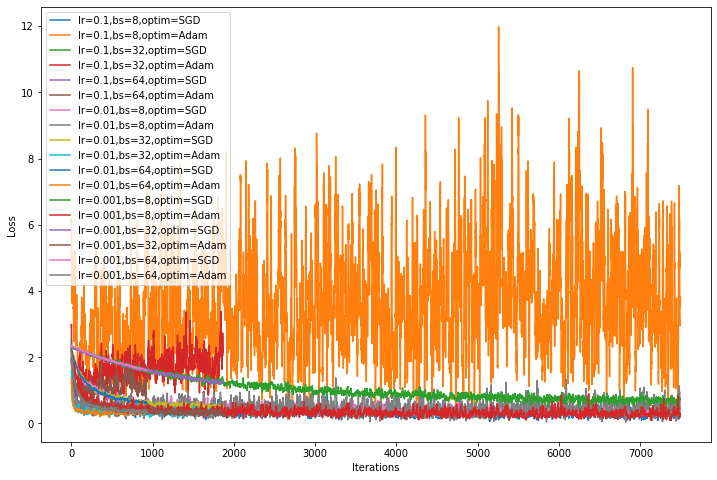

In [10]:
def make_label(lr, bs, optim_cls):
    return f"lr={lr},bs={bs},optim={optim_cls.__name__}"

experiment_results = run_all_experiments(
    OneLayerNetwork,
    lr_space=[1e-1, 1e-2, 1e-3], 
    bs_space=[8, 32, 64], 
    optimizer_space=[torch.optim.SGD, torch.optim.Adam]
)
fig = plot_loss_graph(*[(output['loss_list'], make_label(**inp)) for inp, output in experiment_results])

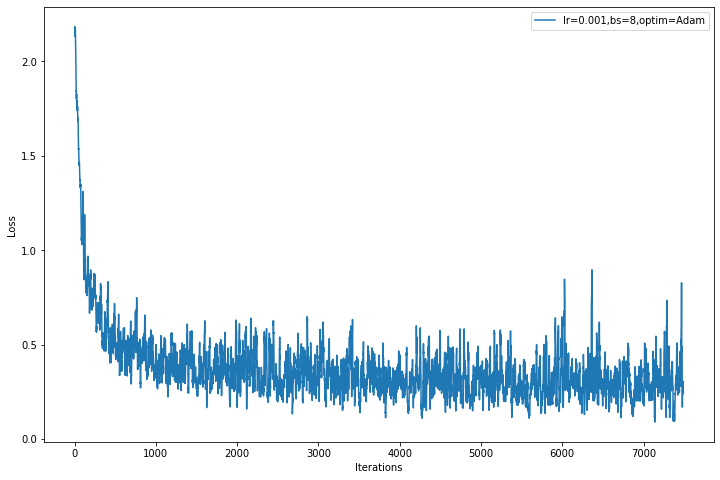

In [12]:
best_experiment = max(experiment_results, key=lambda res: res[1]['accuracy'])
best_model = best_experiment[1]['model']
fig = plot_loss_graph((best_experiment[1]['loss_list'], make_label(**best_experiment[0])))

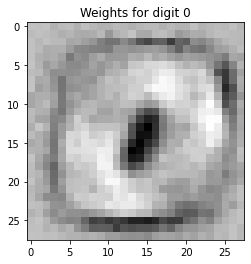

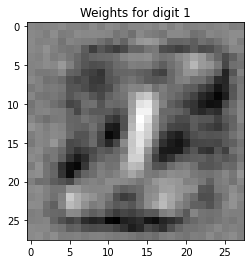

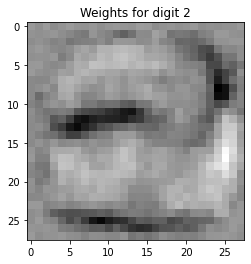

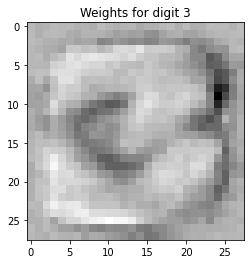

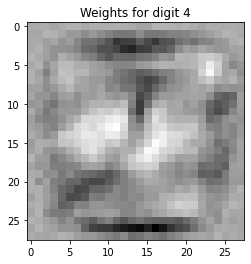

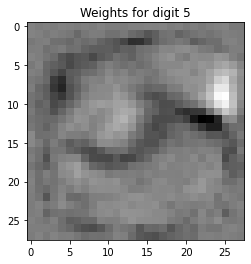

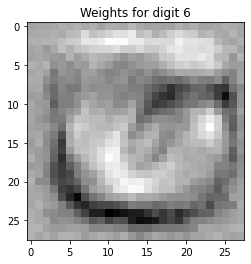

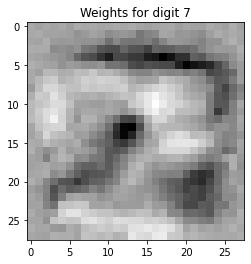

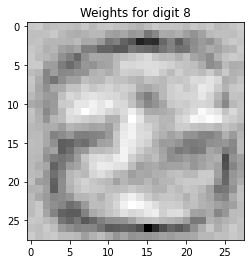

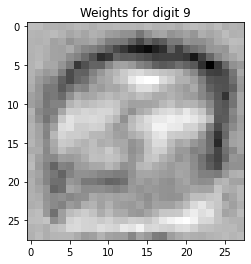

In [15]:
weights = best_model.linear.weight.detach()
for i in range(10):
    plt.figure()
    plt.title(f"Weights for digit {i}")
    plt.imshow(weights[i].cpu().view(28, 28).numpy(), cmap='gray')
    plt.show()

In [16]:
class ThreeLayerNetwork(torch.nn.Module):
    def __init__(self, *hidden_sizes):
      super().__init__()

      sizes = [28*28, *hidden_sizes, 10]
      size_pairs = list(zip(sizes[:-1], sizes[1:]))

      hidden_layers = [
        layer
        for size_pair in size_pairs[:-1]
        for layer in (torch.nn.Linear(*size_pair), torch.nn.ReLU())
     ]

      self.network = torch.nn.Sequential(*hidden_layers, torch.nn.Linear(*size_pairs[-1]))
     
    def forward(self, x):
        return self.network(x)

Three Layer Network (256, 128, 64)
Experiment 1
Learning rate = 0.001
Batch size = 64
Optimizer = Adam
Accuracy = 96.0%
CPU times: user 11.9 s, sys: 132 ms, total: 12 s
Wall time: 12 s


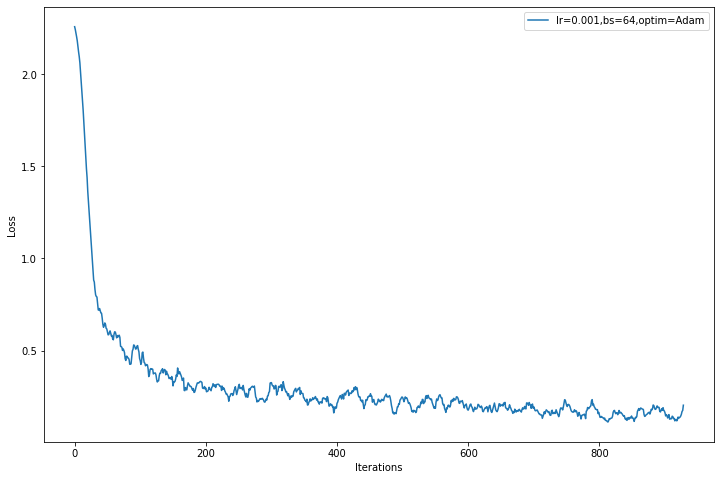

In [17]:
%%time
layer_sizes = (256, 128, 64)
print(f"Three Layer Network { layer_sizes}")
experiment_results = run_all_experiments(
    lambda : ThreeLayerNetwork(*layer_sizes),
    lr_space=[1e-3], 
    bs_space=[64], 
    optimizer_space=[torch.optim.Adam]
)
fig = plot_loss_graph(*[(output['loss_list'], make_label(**inp)) for inp, output in experiment_results])